### Imports

In [160]:
import importlib
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import modules.data_processing
from scipy.stats import ttest_ind, chi2_contingency, percentileofscore

In [260]:
## NLP imports

from textblob import TextBlob
import spacy
import string
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from wikitextparser import remove_markup, parse
from collections import defaultdict


In [86]:
importlib.reload(modules.data_processing)
from modules.data_processing import *

In [97]:
DATA_PATH = './data/wiki-RfA.txt'
EDITORS_PATH = './data/top_editors.txt'
AUTHORS_PATH = './data/top_authors.txt'
CREATORS_PATH = './data/top_creators.txt'

### Extracting Dataset

We start by defining a function that parses the data file and creates a pandas DataFrame containing the parsed data.

In [6]:
wiki_df = extract_data(DATA_PATH)

In [7]:
wiki_df.head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


### Data Processing

Before we start processing data, we need to look at what our parsed dataset looks like in order to use the correct types and to fix any noticebly inconsistent values.

In [8]:
wiki_df.shape

(198275, 7)

In [9]:
wiki_df.columns.values

array(['SRC', 'TGT', 'VOT', 'RES', 'YEA', 'DAT', 'TXT'], dtype=object)

Let's check if there are any columns with NULL or empty values.

In [11]:
null_columns = wiki_df.columns[wiki_df.isnull().any()]
empty_string_columns = wiki_df.columns[(wiki_df == '').any()]



print("Columns containing NULL values:")
print(null_columns)

print("\nColumns containing empty strings:")
print(empty_string_columns)



Columns containing NULL values:
Index([], dtype='object')

Columns containing empty strings:
Index(['SRC', 'DAT', 'TXT'], dtype='object')


We notice there are occurences where the DAT, SRC or TXT is empty.

For DAT and SRC, we replace the empty values by np.nan so we can easility process them later on. <br>
However, the empty TXT values will be treated later when processing the text data.

In [12]:
wiki_df['DAT'].replace('', np.nan, inplace=True)
wiki_df['SRC'].replace('', np.nan, inplace=True)

Now, let us appropriately format the data in the different columns.

In [13]:
wiki_df[['VOT', 'RES', 'YEA']] = wiki_df[['VOT', 'RES', 'YEA']].apply(lambda x: pd.to_numeric(x, errors='coerce'))

# We map RES values to (0, 1) to make them easy to process
wiki_df['RES'] = wiki_df['RES'].apply(lambda x: 1 if x == 1 else 0 )

#### DAT

We format the DAT column, and check which rows have not been correctly formatted.

In [14]:
inconsistent_dates = pd.to_datetime(wiki_df['DAT'], format='mixed', errors='coerce').isna() & (~wiki_df['DAT'].isna())

wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,"14:47, 1 Julu 2012",'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,"20:44, 3 Janry 2010",'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,"31:29, 24 May 2008",Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,"17:44, 26 Mya 2007",'''Support''' You've been doing a great job wi...


We will fix these inconsistent date values one by one.

In [15]:
wiki_df['DAT'] = pd.to_datetime(wiki_df['DAT'], format='mixed', errors='coerce')
wiki_df.at[6821, 'DAT'] = pd.to_datetime('2012-07-01 14:47')
wiki_df.at[27608, 'DAT'] = pd.to_datetime('2010-01-03 20:44')
wiki_df.at[116963, 'DAT'] = pd.to_datetime('2007-05-26 14:47')

In [16]:
wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,2012-07-01 14:47:00,'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,2010-01-03 20:44:00,'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,NaT,Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,2007-05-26 14:47:00,'''Support''' You've been doing a great job wi...


The only remaining issue is with the row n° 70591, the date shows "31:29" which is an invalid hour, in order to fix this issue, we need to look at neighboring votes, as they're sorted mainly chronologically, to infer the correct value.

In [17]:
wiki_df.loc[70589:70593]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
70589,Bhadani,Werdna,1,1,2008,2008-05-24 03:13:00,'''Support''': --
70590,Shanel,Werdna,1,1,2008,2008-05-24 03:18:00,'''Support'''. I have known Werdna for about 1...
70591,Pathoschild,Werdna,1,1,2008,NaT,Support because Shanel told me too. <small>(Gi...
70592,Swatjester,Werdna,1,1,2008,2008-05-24 03:37:00,'''Support''' per lolcat.
70593,KnowledgeOfSelf,Werdna,1,1,2008,2008-05-24 04:37:00,'''Support''' Yes please.


Looking at this, it seems that "31:29" most likely was supposed to be "03:29", we will manually fix this error.

In [18]:
wiki_df.at[70591, 'DAT'] = pd.to_datetime('2008-05-24 03:29')

Finally :

In [19]:
wiki_df[inconsistent_dates]

,SRC,TGT,VOT,RES,YEA,DAT,TXT
6821,JonasEncyclopedia,Zagalejo,1,1,2012,2012-07-01 14:47:00,'''Support'''. A versatile editor and active c...
27608,HJ Mitchell,Alan16,0,0,2010,2010-01-03 20:44:00,'''Neutral'''. Answers to the questions aren't...
70591,Pathoschild,Werdna,1,1,2008,2008-05-24 03:29:00,Support because Shanel told me too. <small>(Gi...
116963,QuasyBoy,Imdanumber1,1,0,2007,2007-05-26 14:47:00,'''Support''' You've been doing a great job wi...


#### SRC

The first problem is finding the reason why the is missing in this column. If we can answer this question, we'll be able to process the data more effectively and thus avoid encountering problems later on when analysing the data.

In [20]:
empty_or_null_src = wiki_df[pd.isna(wiki_df['SRC'])]
non_empty_or_null_src = wiki_df[~pd.isna(wiki_df['SRC'])]
display(empty_or_null_src)

,SRC,TGT,VOT,RES,YEA,DAT,TXT
707,NaN,Jason Quinn,0,1,2013,NaT,
708,NaN,Jason Quinn,0,1,2013,NaT,
793,NaN,Legoktm,1,1,2013,NaT,
1126,NaN,Mattythewhite,-1,1,2013,NaT,
1128,NaN,Mattythewhite,-1,1,2013,NaT,
...,...,...,...,...,...,...,...
198052,NaN,Yelyos,1,0,2004,NaT,
198116,NaN,Christopher Mahan,1,1,2003,NaT,
198171,NaN,Jwrosenzweig,1,1,2003,NaT,
198217,NaN,Patrick,1,1,2003,NaT,


In [22]:
print(f'Number of missing data for SRC column: {len(empty_or_null_src)}')

Number of missing data for SRC column: 1661


We notice that for rows where the SRC value is missing, the TXT value seems to also be missing, let's see if this is the case for all the rows.

In [23]:
empty_or_null_src_txt = empty_or_null_src[pd.isna(empty_or_null_src['TXT']) | (empty_or_null_src['TXT'] == '')]
print(f'Number of missing data for TXT column when SRC is missing: {len(empty_or_null_src_txt)}')

Number of missing data for TXT column when SRC is missing: 1661


We thus find that all the rows where the SRC value is missing, also have the TXT value as missing. Let's now see if the same holds for the DAT value.

In [24]:
empty_or_null_src_dat = empty_or_null_src[pd.isna(empty_or_null_src['DAT'])]
print(f'Number of missing data for DAT column when SRC is missing: {len(empty_or_null_src_dat)}')

Number of missing data for DAT column when SRC is missing: 1661


Thus, whenever the SRC value is missing, the DAT and TXT values are also missing. <br>
The first hypothesis is that it might because of an error in the parsing of the file, however, a manual verification in the raw data file leads to the conclusion that those missing values are not a result of a parsing error.

Let us explore this missing data to see if we can extract any information from it.

First thing we will do is plot the indexes of the missing data, as this can inform us on when missing data happens and whether it has something to do with the ordering in the file.

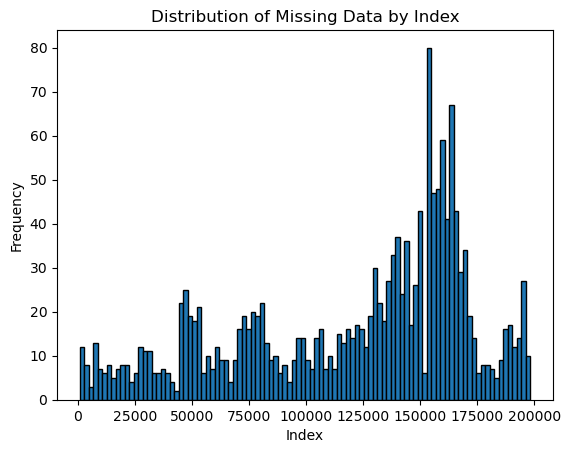

In [25]:
indexes = empty_or_null_src.index

plt.hist(indexes, bins=100, edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Frequency')
plt.title('Distribution of Missing Data by Index')
plt.show()

We can see there is a higher concentration of missing data towards the end of the file, between index 150 000 and index 170 000, signaling there might be a problem with the data in that region of the file. However, we cannot draw conclusions as it can be that missing data is more frequent for a certain year, and that that year is located in that region of the file, for instance.

Which is why we also need to plot the distribution of the missing data throughout the years.

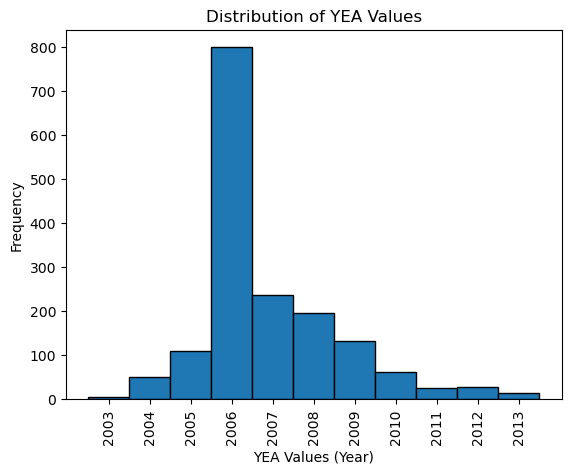

In [33]:
yea_values = empty_or_null_src['YEA']
min_year = min(yea_values)
max_year = max(yea_values)
year_range = max_year - min_year + 1 

plt.hist(yea_values, bins=year_range, range=(min_year - 0.5, max_year + 0.5), edgecolor='k')
plt.xticks(range(min_year, max_year + 1), rotation=90)

plt.xlabel('YEA Values (Year)')
plt.ylabel('Frequency')
plt.title('Distribution of YEA Values')
plt.show()

We can see that the year 2006 has more missing values, however, this could simply be because that year has more data, and thus also more missing data. We need to check the percentage of missing data by year.

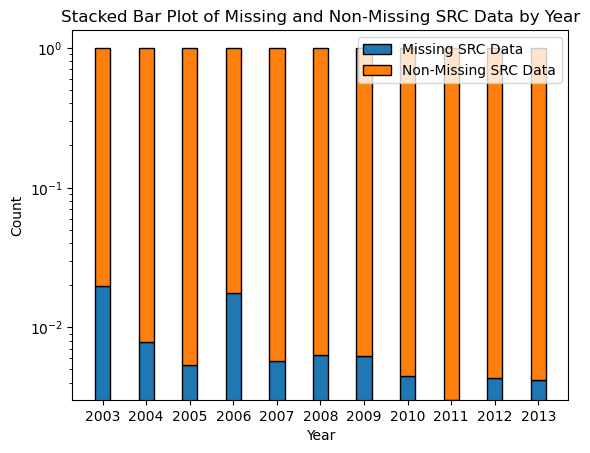

In [34]:
# We get the total number of available (missing or not) data for each year
yearly_data_counts = wiki_df['YEA'].value_counts().sort_index()

# We calculate the percentages of missing data and non missing data.
missing_src_percentages = empty_or_null_src['YEA'].value_counts().sort_index() / yearly_data_counts
non_missing_src_percentages = non_empty_or_null_src['YEA'].value_counts().sort_index() / yearly_data_counts

# We create a stacked bar plot
fig, ax = plt.subplots()
bar_width = 0.35
years = yearly_data_counts.index


plt.bar(years, missing_src_percentages, bar_width, label='Missing SRC Data', edgecolor='k')
plt.bar(years, non_missing_src_percentages, bar_width, label='Non-Missing SRC Data', edgecolor='k', bottom=missing_src_percentages)

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Stacked Bar Plot of Missing and Non-Missing SRC Data by Year')
plt.xticks(years)
plt.yscale('log')
plt.legend()
plt.show()

We see that indeed there is more missing data for the years 2003 and 2006. Now, back to our initial hypothesis, which is that some part of the file might be corrupted, could it be, that for those years, a big part lies between the indexes where most of the missing data happens?

In [35]:
wiki_df.iloc[150000:170000]['YEA'].unique()

array([2006], dtype=int64)

We notice, that in those indexes, there is only votes corresponding to the year 2006, which might explain the number of missing data.

In all cases, the fact that missing data happens in all years, seems to suggest that it isn't an error of parsing but simply a reality that comes with our dataset.

Now, what do we do with this missing data?


First let's take a look at the amount of missing data

In [36]:
missing_src_percentages * 100

YEA
2003    1.970443
2004    0.779697
2005    0.538564
2006    1.765030
2007    0.570521
2008    0.639785
2009    0.622222
2010    0.450966
2011    0.303880
2012    0.432499
2013    0.419933
Name: count, dtype: float64

We have less than 1% of missing data for all the years except for the years 2003 and 2006 where we have less than 2%.

It appears that the missing data in this dataset may signify instances where users' accounts were potentially deleted or encountered other similar issues. While retaining their votes to justify election outcomes, the remaining data could have been discarded for GDPR compliance. An exploration could investigate whether this absence of data influences election results by comparing elections with and without missing data. Such analysis might reveal any discrepancies in the displayed results in the 'RES' column. 

Because of this, we have decided to keep those votes when analysing the data.

##### Grouping Elections 

In order to analyse the elections' data, we need to draw a line between different elections. Fortunately, it seems that in our data file, the votes are ordered by election and by time, meaning, when a candidate changes in the data, that means that the vote is for a new election.

We use that information to identify different elections.

In [60]:
wiki_df['ELECTION_ID'] = 0
current_id = 1

for index, row in wiki_df.iterrows():
    tgt_value = row['TGT']
    
    if index > 0 and wiki_df.at[index - 1, 'TGT'] != tgt_value:
        current_id += 1  # Increment ELECTION_ID for a new 'TGT' value
    
    wiki_df.at[index, 'ELECTION_ID'] = current_id

In [61]:
display(wiki_df)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1
...,...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support,3926
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.,3927
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --,3927
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....,3927


We have given consecutive rows with the same "TGT" value the same ELECTION_ID value, however, we have not yet verified if there are instances where non-consecutive rows with the same "TGT" value belong to the same election.<br> To identify this, we will group by ELECTION_ID values and look at groups that have less than 5 voters, as this might signify that there is a problem with the grouping, we will then analyze some of these occurences to see if we can draw any conclusions from them.

In [62]:
grouped_elections = wiki_df.groupby('ELECTION_ID').size()
grouped_elections[grouped_elections <= 5]

ELECTION_ID
70      3
71      5
117     2
125     4
127     3
       ..
3924    5
3925    3
3926    3
3927    3
3928    1
Length: 335, dtype: int64

Let's take the election with id 70 and see why it has so little voters. We will look at the rows with that Election_ID, and then we will look at all rows with that election 'TGT' to see if we are missing some votes.

In [64]:
wiki_df[wiki_df['ELECTION_ID'] == 70]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
7329,Cyberpower678,Baseballrocks538,-1,0,2012,2012-03-06 23:15:00,'''Strongest Oppose''' This user clearly does ...,70
7330,Eagles247,Baseballrocks538,-1,0,2012,2012-03-06 23:16:00,'''Oppose''' per warnings on user's talk page....,70
7331,SarekOfVulcan,Baseballrocks538,-1,0,2012,2012-03-06 23:17:00,"Sorry, but [[WP:NOTYET]]. You need a lot more ...",70


In [65]:
wiki_df[wiki_df['TGT'] == 'Baseballrocks538']

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
7329,Cyberpower678,Baseballrocks538,-1,0,2012,2012-03-06 23:15:00,'''Strongest Oppose''' This user clearly does ...,70
7330,Eagles247,Baseballrocks538,-1,0,2012,2012-03-06 23:16:00,'''Oppose''' per warnings on user's talk page....,70
7331,SarekOfVulcan,Baseballrocks538,-1,0,2012,2012-03-06 23:17:00,"Sorry, but [[WP:NOTYET]]. You need a lot more ...",70


As we can see, it seems that the "Baseballrocks538" has indeed only received three votes, and that it doesn't come from a problem in our grouping.

Let's take an occurence where a same TGT corresponds to more than one ELECTION_ID, and analyse the different election groups.

In [70]:
unique_election_id_counts = wiki_df.groupby('TGT')['ELECTION_ID'].nunique()
unique_election_id_counts[unique_election_id_counts > 2]

TGT
Carnildo             3
Cobi                 3
Cool3                3
Curtis23             3
Elonka               3
Enigmaman            3
Everyking            6
Firefoxman           3
Footballfan190       3
Geni                 3
Guanaco              4
HJ Mitchell          3
Hex                  3
Ironholds            4
Juliancolton         3
Ktr101               4
Kww                  3
Leonard^Bloom        3
MONGO                3
MZMcBride            4
MoRsE                3
Porchcrop            3
Richardcavell        3
Robchurch            3
ST47                 3
Sceptre              3
Shoessss             3
Slon02               3
TenPoundHammer       3
The Transhumanist    4
Thumperward          3
Werdna               3
Wikiwoohoo           4
ZooPro               3
^demon               3
Name: ELECTION_ID, dtype: int64

Let's take the user 'Carnildo' for instance and look at the different election groups to which he belongs.

In [71]:
carnildo_df = wiki_df[(wiki_df['TGT'] == 'Carnildo')]
carnildo_df['ELECTION_ID'].unique()

array([2239, 2608, 3064], dtype=int64)

In [72]:
carnildo_df[carnildo_df['ELECTION_ID'] == 2239].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
129888,UninvitedCompany,Carnildo,1,1,2006,2006-08-18 22:48:00,,2239
129889,Chacor,Carnildo,1,1,2006,2006-08-29 03:05:00,"This is bound to be a controversial RFA, but e...",2239
129890,crazytales56297,Carnildo,1,1,2006,2006-08-29 03:07:00,'''Support''' per Chacor. <!--begin crazytales...,2239
129891,Sean Black,Carnildo,1,1,2006,2006-08-29 03:09:00,--[[Special:Contributions/Sean Black|SB]] |,2239
129892,Mindspillage,Carnildo,1,1,2006,2006-08-29 03:20:00,'''Support'''. I believe the incident for whic...,2239


In [73]:
carnildo_df[carnildo_df['ELECTION_ID'] == 2608].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
155749,Jahiegel,Carnildo,1,0,2006,2006-03-20 21:36:00,I've been waiting for Carnildo to accept and a...,2608
155750,RN,Carnildo,1,0,2006,2006-03-20 22:06:00,[[Image:Symbol support vote.svg|15px]] '''Supp...,2608
155751,BD2412,Carnildo,1,0,2006,2006-03-20 22:11:00,"''NEVER!!!'' Oh, wait, this is ''[[User:Carnil...",2608
155752,Rune.welsh,Carnildo,1,0,2006,2006-03-20 22:28:00,'''Strong support'''. His work regarding image...,2608
155753,Alhutch,Carnildo,1,0,2006,2006-03-20 22:43:00,'''Support''' per Rune. good user.--,2608


In [74]:
carnildo_df[carnildo_df['ELECTION_ID'] == 3064].head(5)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
173443,Redwolf24,Carnildo,1,1,2005,2005-08-13 01:34:00,"<font size=""+2"">SUPPORT!</font>",3064
173444,Starblind,Carnildo,1,1,2005,NaT,"'''Strong Support''' Excellent editor, strong ...",3064
173445,RN,Carnildo,1,1,2005,2005-08-13 03:57:00,'''Strong Support''' He can be a bit confrenta...,3064
173446,Denelson83,Carnildo,1,1,2005,2005-08-13 06:06:00,"'''Support!''' Support! Support! <span style=""...",3064
173447,Merovingian,Carnildo,1,1,2005,NaT,,3064


As we can see, the different ELECTION_ID correspond indeed to different elections.

We can also notice that a candidate can run for elections multiple times, even in the same year, which is why it is important to group elections in the order they appear in rather than taking the "YEA" column value for instance. Moreover, we notice that a candidate can run another time, even after winning an election, which is an odd occurence as adminship is supposed to be a definitive status, so how can it be that someone can run for adminship again, even after supposedly being elected the first time?

Let's see how many times that occur. We first group by elections, and then group by candidate, summing the results of the election. If the value is greater than 1, than means the candidate has won more than 1 election.

In [75]:
grouped_elections = wiki_df[['ELECTION_ID', 'RES', 'TGT']].drop_duplicates()
won_elections = grouped_elections.groupby('TGT')['RES'].sum()

In [76]:
print(f'Number of candidates having won more than one election: {len(won_elections[won_elections > 1])}\n')
display(won_elections[won_elections > 1])

Number of candidates having won more than one election: 18



TGT
Carnildo           2
Croat Canuck       2
Danny              2
Evercat            2
Everyking          2
Geni               2
Guanaco            2
HJ Mitchell        2
MZMcBride          2
Nev1               2
PMelvilleAustin    2
PeterSymonds       2
SarekOfVulcan      2
Sarge Baldy        2
Sean Black         2
Ugen64             2
W.marsh            2
^demon             2
Name: RES, dtype: int64

As we can see, there are 18 candidates who have one more than one election (precisely, two elections).

A quick look at Carnildo's history, shows us that he has been 'resysopped', meaning reelected (cf: https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_Signpost/2006-09-11/Carnildo_resysopped), which explains the fact that he has won two elections.

In fact, we find out that all the candidates in the list were reelected as well, as their names can be found in Wikipedia's list of resysopped users: https://en.wikipedia.org/wiki/Wikipedia:List_of_resysopped_users.

#### Text Processing

### Text preprocessing

In [241]:
len(wiki_df[wiki_df['TXT'] == '']['TXT'])

7190

* We notice that we have 7190 missing values among comments. 

We don't do the replacement at this stage of empty comments by NaN, because we intend to maintain them as strings for the following steps. 

#### Removing the Wiki Markup from the comments

In [244]:
# Make sure that TXT is string
wiki_df['TXT'] = wiki_df['TXT'].astype(str)

* We will try to use a python library called "wikitextparser" to easily remove the wiki markup. 

In [246]:
# comment example from the dataset 
example = wiki_df.iloc[66609]['TXT']
example

"Congratulatory '''Support''' - Excellent [[Wikipedia:WikiProject Military history|WikiProject:Military history]] experience with this user. Can be trusted with new responsibility."

In [247]:
remove_markup(example)

'Congratulatory Support - Excellent WikiProject:Military history experience with this user. Can be trusted with new responsibility.'

* The library didn't handle the link removal as expected. Therefore, we will implement a classic function using regular expressions to remove the wiki markup, relying on the Wikitext structure on the website [Wikitext](https://en.wikipedia.org/wiki/Help:Wikitext).

In [248]:
remove_wiki_markup(example)

'Congratulatory Support - Excellent  experience with this user. Can be trusted with new responsibility.'

* The results is indeed what we want. Let's test on a random sample of comments.

In [249]:
txts = wiki_df['TXT'].sample(10).copy()
for i, comment in enumerate(txts): 
    print(i, ' : ' , comment)
    print() 

0  :  '''Support'''&mdash; Serious contributions like [[Carl Friedrich Gauss|Gauss]] and [[Leonhard Euler|Euler]] &mdash; dedication to the articles success is evident. AfD actions solidly supported &mdash; I may not agree with your determinations, but you told me the basis for your position & didn’t just give me more “per nom”.  Overall you have the breadth of experience that makes me comfortable supporting you toward knighthood with the power of blocking & unblocking editors, deleting & undeleting pages, performing complex moves, page protection and enforcing arbitration rulings. Use these powers for good, not evil!

1  :  '''Support''' per amusing username, err, per good work against vandals and the like.

2  :  '''Support'''- per Good Editor who needs admin tools.--

3  :  '''Support'''. However, for the record I would like to show that I am pretty sure that Bonaparte has ulterior motives here. --

4  :  '''Neutral''' I recognise your efforts to improve the information to cricket r

In [250]:
for i, comment in enumerate(txts): 
    print(i, ' : ' , remove_wiki_markup(comment))
    print() 

0  :  Support Serious contributions like  and   dedication to the articles success is evident. AfD actions solidly supported  I may not agree with your determinations, but you told me the basis for your position & didn’t just give me more “per nom”.  Overall you have the breadth of experience that makes me comfortable supporting you toward knighthood with the power of blocking & unblocking editors, deleting & undeleting pages, performing complex moves, page protection and enforcing arbitration rulings. Use these powers for good, not evil!

1  :  Support per amusing username, err, per good work against vandals and the like.

2  :  Support- per Good Editor who needs admin tools. 

3  :  Support. However, for the record I would like to show that I am pretty sure that Bonaparte has ulterior motives here.  

4  :  Neutral I recognise your efforts to improve the information to cricket related topics, but this "As for the infantiles who write rude words and then run off laughing, the quick re

* It seems that it works well on the comments of our dataset. We create then a column for cleaned comments.

In [251]:
wiki_df['CLE'] = wiki_df['TXT'].apply(remove_wiki_markup)
wiki_df.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,Support as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,Support as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,Support per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,Support per noms. BDD is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,"Support, with great pleasure. I work with BDD ..."


In [252]:
comments_with_one_char = wiki_df.loc[(wiki_df['CLE'].apply(len) == 1)]['CLE'].unique() # one char in the comments
comments_with_one_char

array([' ', '—', '-', '+', '→', "'", '.', '}', '!', '–', 'S', '·', 'I',
       '~', '«', '↔', 'C', ':', '(', '"', '/'], dtype=object)

In [253]:
comments_with_two_char = wiki_df.loc[(wiki_df['CLE'].apply(len) == 2)]['CLE'].unique() # two char in the comments
comments_with_two_char

array(['  ', '- ', ' /', '— ', '+ ', '←.', ' [', '. ', "''", ' (', '⇦⇨',
       ' —', 'OK', '}—', ' -', "':", '我是', '++', 'CO', '~ ', ' ~', ' C',
       'Q8', ' ☺', 'No', ' 〈', 'Da', 'S.', '! ', ':)'], dtype=object)

* We will delete those comments containing one or two characters that are meaningless for our study.

In [254]:
wiki_df['CLE'] = wiki_df['CLE'].apply(lambda x: '' if len(x) < 3 and x not in ['OK', 'No']  else x)
wiki_df.loc[(wiki_df['CLE'].apply(len) < 3)]['CLE'].unique()

array(['', 'OK', 'No'], dtype=object)

In [256]:
wiki_df.loc[(wiki_df['CLE'].apply(len) == 3)]['CLE'].unique()

array(['←  ', '!!!', '   ', ' - ', 'Ja.', 'OK.', "I'm", 'Yes', '.  ',
       " ''", '+1–', '賛成 ', ' ••', '} —', '他是好', 'wow', '  ~', "'' ",
       ' ~~', 'No ', '^.^', 'S+1', "''÷", 'yup', ' – ', '➲  ', 'Yay',
       '  |', 'Q3.', '  (', 'yes', '-  ', 'Yup', '➔  ', 'Aye', '➨  ',
       'Q1.', '9 (', '...', 'No.', 'Yep', ' — ', '— (', '— [', '. —',
       "—''", ' :)', ' (/', ' (|', 'yep', '}} ', 'Baa', 'Moo', 'Ok.',
       '!  ', "— '", '. -', ':) ', 's  ', ". '", ' ;)', 'Yo.', ' ()',
       ' ("', ':-)', 'NO.'], dtype=object)

In [258]:
wiki_df.loc[(wiki_df['CLE'].apply(len) == 4)]['CLE'].unique()

array(['. - ', 'Yay.', 'Q2 -', 'Sure', 'Yup.', 'Wow.', '.   ', " - '",
       'Yes.', " I'm", 'Duh.', 'Oui ', 'I  /', 'Yeps', '  — ', 'Yes!',
       'Yep.', '. ? ', 'Oui.', 'jo  ', '+1  ', 'Yes ', 'Yep!', ' .  ',
       'See ', '. ~~', 'NEWT', '  (|', '. – ', ' . —', 'AGF ', 'FGJ–',
       'yup.', 'Yep ', '➨ ❝❞', 'Duh!', '-   ', '   ·', 'DUH!', 'Aye.',
       'Meh.', ". ''", "! ''", 'Nom.', '  . ', ' ...', '. — ', "Q5 '",
       'okay', 'Aww.', 'Yup ', 'I am', 'Yea.', ',   ', 'Pig.', '  (/',
       'Yo. ', 'Mop.', 'Wow!', '100%', 'Yes,', "I'm ", 'No. ', 'Bleh',
       '   (', 'Да! ', 'Yay!', '.  |', ' ( -', '«»(|', ', . ', 'TAK!',
       '<3  ', 'yes!', 'Moo.', 'Cool', 'Hai ', 'Pro.', 'Sup ', 'YES!',
       'Ja! ', ' ort', 'yep.', 'Who?', 'Yup,', 'No  ', 'Heh.'],
      dtype=object)

In [259]:
wiki_df.loc[(wiki_df['CLE'].apply(len) == 5)]['CLE'].unique()

array(['100%.', 'Yo.  ', 'Yes! ', 'Q2. -', 'Aye.—', 'Sure.', 'nods ',
       'Meh -', 'Yerp.', 'Uhhhh', 'Per .', 'Sold.', 'Duh →', 'Sure ',
       'sure ', 'Yes  ', 'Solid', "Yep '", 'AGF  ', '.    ', 'Okay.',
       'Fine.', '    ·', 'Yup. ', 'Yes. ', 'Yup  ', 'No.  ', 'Yes —',
       'Damn,', 'Nom  ', 'Desu.', 'Yep. ', '.   (', 'Aye. ', 'Ok. —',
       '+S . ', '+S  (', ' () (', 'Aye  ', 'OK.  ', 'ok. —', '+1.  ',
       'Yup! ', 'Duh. ', 'PRO -', 'YES  ', '...  ', 'yes. ', 'Moo  ',
       'AGF. ', 'Oops.', 'Hut+!', 'See .', 'Yep  ', 'Yeap ', 'GL. –',
       ' ..  ', ' ⁿɡ͡b', 'Cool.', 'Fish.', "Sure'", 'Yes..', 'Yup..',
       'Oui!.', ". —''", 'Sure!', 'YEs. ', 'Yay. ', ".  ''", 'Duh .',
       'Gasp!', 'Mooo.', 'Agree', 'Yeah.', 'Sì.  ', 'TINC.', 'Frog.',
       'w00t.', 'SNFA.', 'Aye =', 'Duh  ', 'Okay!', 'Duh -', 'What?',
       'AOL!>', 'No ()', 'Ok.  ', 'Sí.  ', 'Mhmm.', 'Da.  ', '-"-  ',
       'No. -'], dtype=object)

When examining comments with a length greater than 2, we find various words and special characters that we cannot eliminate at this point. 
Due to the extensive number of words and special characters, exhaustive treatment of these comments (by studying the different combinaisons) becomes challenging. 

* Let's see then what are the words by which comments start.

In [262]:
cleaned_comments = wiki_df['CLE']

first_word_counts = defaultdict(int)
for comment in cleaned_comments: 
    if isinstance(comment, str) and comment.strip(): 
        first_word = comment.split()[0]
        first_word_counts[first_word] += 1
i = 0       
for word, count in first_word_counts.items(): 
    print(word, ', Occurrence :', count)
    if i == 15: 
        break
    i += 1

Support , Occurrence : 68955
Support, , Occurrence : 7585
Yea, , Occurrence : 6
Support. , Occurrence : 23921
If , Occurrence : 108
Weak , Occurrence : 3370
Support: , Occurrence : 1661
. , Occurrence : 165
Support...opposes , Occurrence : 1
Oppose. , Occurrence : 5538
Although , Occurrence : 68
Oppose , Occurrence : 21033
Fruitless , Occurrence : 3
Neutral , Occurrence : 5864
Yes , Occurrence : 153
Strong , Occurrence : 8394


In [265]:
# Some comments have become empty
# After the wiki markup removal
len(wiki_df[wiki_df['CLE'] == '']['CLE'])

9387

* In the cleaned comments, we have now 9387 missing values compared to the initial count of 7190. 

Let's take a look at the additional empty comments resulting from our processing.

In [267]:
wiki_df[(wiki_df['CLE'] == '') & (wiki_df['TXT'] != '') ]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
156,Rzuwig,Bilby,1,1,2013,2013-05-25 07:11:00,{{pro}} --,2,
276,Mabdul,Darkwind,1,1,2013,2012-12-26 20:39:00,"<small style=""font: 12px Courier New; color: #...",3,
300,Filelakeshoe,Darkwind,1,1,2013,2012-12-27 21:58:00,"<font face=""trebuchet MS"">- [[User:Filelakesho...",3,
427,LlamaAl,INeverCry,1,1,2013,2013-01-31 13:17:00,--,4,
441,Jan eissfeldt,INeverCry,1,1,2013,2013-01-31 20:03:00,--,4,
...,...,...,...,...,...,...,...,...,...
197931,Hcheney,Snowspinner,1,0,2004,2004-05-30 22:25:00,[[User:Hcheney/Support|Support]] --,3864,
197938,Anthony DiPierro,Snowspinner,1,0,2004,NaT,[[User:Hcheney/Support|Support]] [[User:Anthon...,3864,
197940,GeneralPatton,Snowspinner,1,0,2004,2004-06-02 18:13:00,--,3864,
197944,Texture,Snowspinner,1,0,2004,2004-06-04 14:30:00,[[User:Texture|<font color=red>T&#949;x</font>...,3864,


We can see that these comments initially contained only pure WikiMarkup and didn't contain any useful information for our analysis.

### Resulting Dataframes 

Now that we have processed the data, we will create new dataframes containing statistics about the individuals and the elections that can be directly used when working with the data.

Let's start with the elections, we group the same elections and, as we did earlier, get the :
- Candidate
- Year
- Number of positive, neutral and negative votes.
- Percentage of positive, neutral and negative votes.
- Total number of votes
- Earliest and latest voting date.

For this, we define a function that directly does the grouping and the aggregation.

In [215]:
elections_df = create_elections_df(wiki_df)

In [216]:
elections_df.head(5)

,ELECTION_ID,TGT,RES,Total Votes,Positive Votes,Negative Votes,Neutral Votes,Positive Percentage,Negative Percentage,Neutral Percentage,Earliest Voting Date,Latest Voting Date
0,1,BDD,1,137,119,14,4,86.861314,10.218978,2.919708,2013-04-19 23:13:00,2013-04-26 22:12:00
1,2,Bilby,1,137,134,2,1,97.810219,1.459854,0.729927,2013-05-25 00:37:00,2013-06-01 13:13:00
2,3,Darkwind,1,146,108,30,8,73.972603,20.547945,5.479452,2012-12-26 20:12:00,2013-01-02 21:23:00
3,4,INeverCry,1,110,101,8,1,91.818182,7.272727,0.909091,2013-01-31 08:17:00,2013-02-07 02:27:00
4,5,Jason Quinn,1,183,138,29,16,75.409836,15.846995,8.743169,2013-01-25 03:30:00,2013-02-01 00:08:00


Now, we create a dataframe that contains the following information about candidates:
- The number of times they run for an election
- The number of times they won
- The number of times they lost
- The number of votes they received
- The percentage of positive votes they received
- The percentage of negative votes they received
- The percentage of neutral votes they received
- The average length of the comments they received

In [87]:
candidates_df = create_candidates_df(wiki_df)

In [93]:
candidates_df.head(10)

,USER,Number of Elections,Won Elections,Lost Elections,Votes Received,Positive Percentage,Negative Percentage,Neutral Percentage,Average Length Received
0,(aeropagitica),1,1,0,55,0.727273,0.181818,0.090909,106.672727
1,07bargem,1,0,1,6,0.000000,1.000000,0.000000,278.500000
2,1234r00t,1,0,1,6,0.000000,1.000000,0.000000,275.333333
3,168...,1,1,0,7,1.000000,0.000000,0.000000,42.000000
4,21655,1,0,1,24,0.166667,0.750000,0.083333,324.833333
5,23skidoo,1,1,0,58,1.000000,0.000000,0.000000,50.637931
6,28bytes,2,1,1,188,0.840426,0.132979,0.026596,217.938859
7,2over0,1,1,0,94,1.000000,0.000000,0.000000,106.765957
8,4836.03,1,0,1,26,0.076923,0.769231,0.153846,123.153846
9,5 albert square,1,1,0,104,0.971154,0.019231,0.009615,141.538462


Now, we create a dataframe that contains the following information about candidates:
- The years they were active in
- The number of votes they cast
- The percentage of positive votes they cast
- The percentage of negative votes they cast
- The percentage of neutral votes they cast
- The percentage of times they voted similarly to the election result
- The percentage of times they voted differently than the election result
- The average length of the comments they cast

In [89]:
voters_df = create_voters_df(wiki_df)

In [92]:
voters_df.head(10)

,USER,Active Years,Votes Count,Positive Percentage,Negative Percentage,Neutral Percentage,Voted Differently,Voted Similarly,Average Length Cast
0,!---slappdash---!,[2009],1,100.000000,0.000000,0.000000,0.000000,100.000000,105.000000
1,%D0%90,[2006],13,100.000000,0.000000,0.000000,15.384615,84.615385,60.692308
2,'sed,[2006],3,100.000000,0.000000,0.000000,66.666667,33.333333,90.666667
3,(.Y.),[2006],1,100.000000,0.000000,0.000000,0.000000,100.000000,58.000000
4,(:Julien:),[2005],1,100.000000,0.000000,0.000000,0.000000,100.000000,98.000000
5,(aeropagitica),"[2008, 2007, 2006]",442,57.692308,19.457014,22.850679,30.769231,69.230769,278.911765
6,*Kat*,"[2011, 2009, 2006]",5,80.000000,20.000000,0.000000,40.000000,60.000000,222.800000
7,*Spark*,[2006],1,100.000000,0.000000,0.000000,0.000000,100.000000,13.000000
8,*drew,"[2007, 2006, 2005]",29,75.862069,24.137931,0.000000,27.586207,72.413793,32.758621
9,-Midorihana-,"[2008, 2007]",75,84.000000,5.333333,10.666667,10.666667,89.333333,130.013333


### Additional Datasets

Since our goal is to analyse the reasons motivating people's votes, we need metrics to evaluate the productivity of users. For this reason, we use additional datasets that contain statistics about Wikipedia users, namely: the number of pages they created, the number of articles they wrote, and the number of edits they made.

Those datasets are taken from the following Wikipedia articles:

Number of pages created: https://en.wikipedia.org/wiki/User:Bryan/List_of_users_by_pages_created <br>
Number of articles: https://en.wikipedia.org/wiki/Wikipedia:List_of_Wikipedians_by_article_count <br>
Number of edits: https://en.wikipedia.org/wiki/Wikipedia:List_of_Wikipedians_by_number_of_edits <br>

The extracted data files are in the "data" folder, while the functions used to parse and format them are in the "data_processing" module.

In [98]:
editors_df = parse_other_datasets(EDITORS_PATH)
authors_df = parse_other_datasets(AUTHORS_PATH)
creators_df = parse_other_datasets(CREATORS_PATH)

format_editors_df(editors_df)
format_authors_df(authors_df)
format_creators_df(creators_df)

The edits' dataset contains additional information about the category of users the user belong to.

- AC	Account creator <br>
- Ad	Administrator <br>
- AP	Autopatrolled <br>
- B	Bureaucrat <br>
- Ch	CheckUser <br>
- Co	Confirmed <br>
- ECo	Extended confirmed <br>
- EFH	Edit filter helper <br>
- EFM	Edit filter manager <br>
- EM	Extended mover <br>
- EvCo	Event coordinator <br>
- F	File mover <br>
- IM	Import <br>
- IAd	Interface administrator <br>
- IP	IPblock-exempt <br>
- MM	Mass message senders <br>
- N	New page reviewer <br>
- O	Oversighter <br>
- Ro	Rollbacker <br>
- Rs	Researcher <br>
- Rv	Pending changes reviewer <br>
- TE	Template editor <br>

In [105]:
display(editors_df)

,RANK,USER,NB_EDITS,CAT
0,1,Ser Amantio di Nicolao,5705768,"AP, Ad"
1,2,BrownHairedGirl,2942733,"AP, ECo, EM, F, N, Rv, Ro, TE"
2,3,Jevansen,2408733,"AP, ECo, EM, Rv, Ro"
3,4,BD2412,2262281,"AP, IP, Ad"
4,5,Koavf,2153268,"AP, ECo, EM, F, N, Rv, Ro, TE"
...,...,...,...,...
9995,9996,Canis Lupus,11066,None
9996,9997,Shanel,11065,ECo
9997,9998,Cornellier,11064,"ECo, Rv"
9998,9999,Pink Fae,11064,"AP, ECo, Rv"


In [106]:
display(authors_df)

,RANK,USER,NB_ARTICLES
0,1,Yankees10,4821
1,1,Davidlofgren1996,4821
2,1,Kwamikagami,4821
3,1,Number 57,4821
4,1,Philafrenzy,4821
...,...,...,...
9996,9996,Kemkim,70
9997,9997,Karantsingh,70
9998,9998,Kaibabsquirrel,70
9999,9999,Jonyungk,70


In [107]:
display(creators_df)

,RANK,USER,NB_PAGES
0,1,Kotbot,55605
1,2,Dr. Blofeld,49089
2,3,Polbot,40174
3,4,Ram-Man,35076
4,5,AlbertHerring,14692
...,...,...,...
4995,4996,DavidCane,66
4996,4997,D Monack,66
4997,4998,Cwebb4,66
4998,4999,Colonies Chris,66


### Data Exploration

In this notebook, we analyse various variables influencing the acceptance or rejection of candidates in elections, aiming to uncover the factors leading to a successful outcome.

#### General Data Exploration

Let us look at the percentage of elections lost and won.

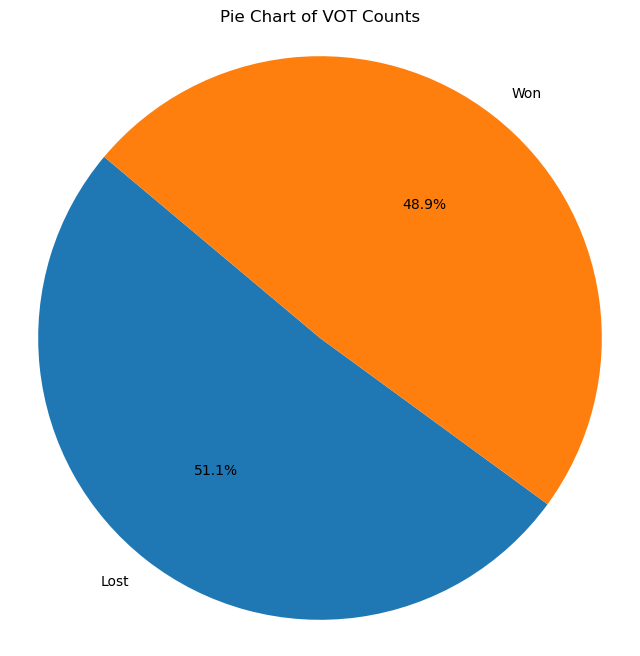

In [238]:
election_results_counts = elections_df['RES'].value_counts()

label_map = {1: 'Won', 0: 'Lost'}
election_labels = [label_map[val] for val in election_results_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(election_results_counts, labels=election_labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of VOT Counts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.show()

In [239]:
print(f'Total Number of Elections: {len(elections_df)}')

Total Number of Elections: 3928


We can see that we have 51% of elections lost, and 49% of elections won, and a total of 3928 elections.

We first start by doing a general data exploration to better understand the nature of our dataset and the conclusions we can draw from analysing it.

Let's take a look at the number of unique voters in the dataset.

In [109]:
print(f'Number of unique voters : {len(voters_df)}')

Number of unique voters : 10416


In [115]:
print(f'Number of unique members (either voters or candidates) : {len(pd.concat([voters_df["USER"], candidates_df["USER"]]).unique())}')

Number of unique members (either voters or candidates) : 11380


We can be more precise and look at the evolution of the number of voters per year. 

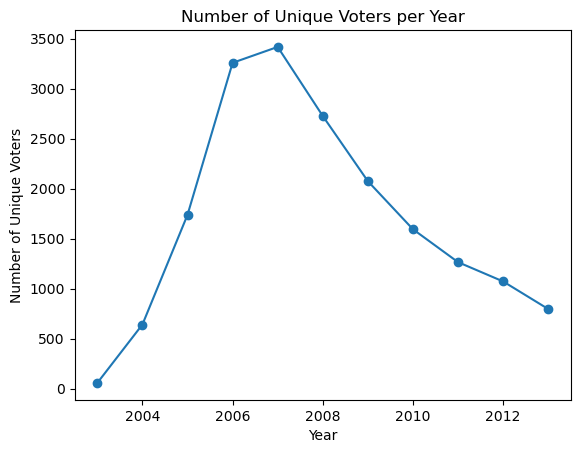

In [116]:
unique_voters_per_year = wiki_df.groupby(wiki_df['YEA'])['SRC'].nunique()

plt.plot(unique_voters_per_year.index, unique_voters_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Unique Voters')
plt.title('Number of Unique Voters per Year')
plt.show()

In [117]:
print(f'Average number of unique voters per year: {unique_voters_per_year.mean(): 0.0f}')

Average number of unique voters per year:  1694


We can see that the number of voters peaks for the years 2006 and 2007 and then slowly decreases again, with an average of 1694 voters per year.

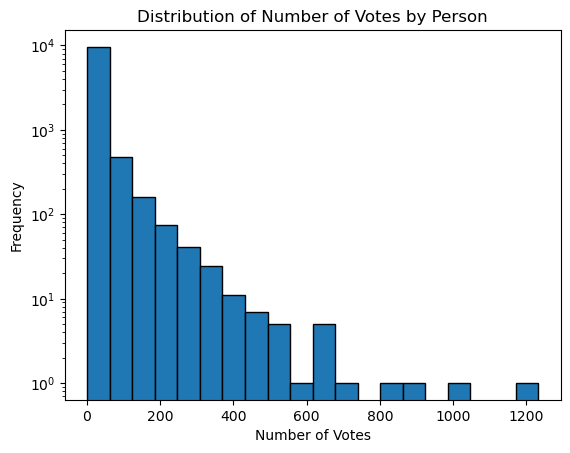

In [124]:
votes_distribution = voters_df['Votes Count']

plt.hist(votes_distribution, bins=20, edgecolor='k')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Distribution of Number of Votes by Person')
plt.show()

In [126]:
# Top voters
voters_df.nlargest(10, 'Votes Count')

,USER,Active Years,Votes Count,Positive Percentage,Negative Percentage,Neutral Percentage,Voted Differently,Voted Similarly,Average Length Cast
8222,Siva1979,"[2010, 2009, 2008, 2007, 2006]",1232,81.006494,14.285714,4.707792,39.285714,60.714286,149.906656
5571,Mailer diablo,"[2012, 2011, 2009, 2008, 2007, 2006, 2005]",998,79.659319,11.823647,8.517034,23.647295,76.352705,35.943888
5865,Merovingian,"[2009, 2008, 2007, 2006, 2005, 2004]",916,86.026201,5.895197,8.078603,22.707424,77.292576,21.573144
9874,Wizardman,"[2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006]",810,77.160494,18.148148,4.691358,38.888889,61.111111,104.849383
223,Acalamari,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",726,96.694215,2.341598,0.964187,27.134986,72.865014,183.603306
9968,Xoloz,"[2008, 2007, 2006, 2005]",677,46.085672,51.698671,2.215657,59.231905,40.768095,162.568685
6925,Pedro,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",663,69.834087,21.870287,8.295626,42.081448,57.918552,392.788839
2517,Dlohcierekim,"[2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006]",661,76.399395,17.700454,5.900151,41.754917,58.245083,233.453858
1003,Bearian,"[2013, 2012, 2011, 2010, 2009, 2008, 2007]",635,80.000000,8.188976,11.811024,27.086614,72.913386,156.757480
8571,Stifle,"[2013, 2011, 2010, 2009, 2008, 2007, 2006]",628,53.662420,32.484076,13.853503,49.203822,50.796178,83.853503


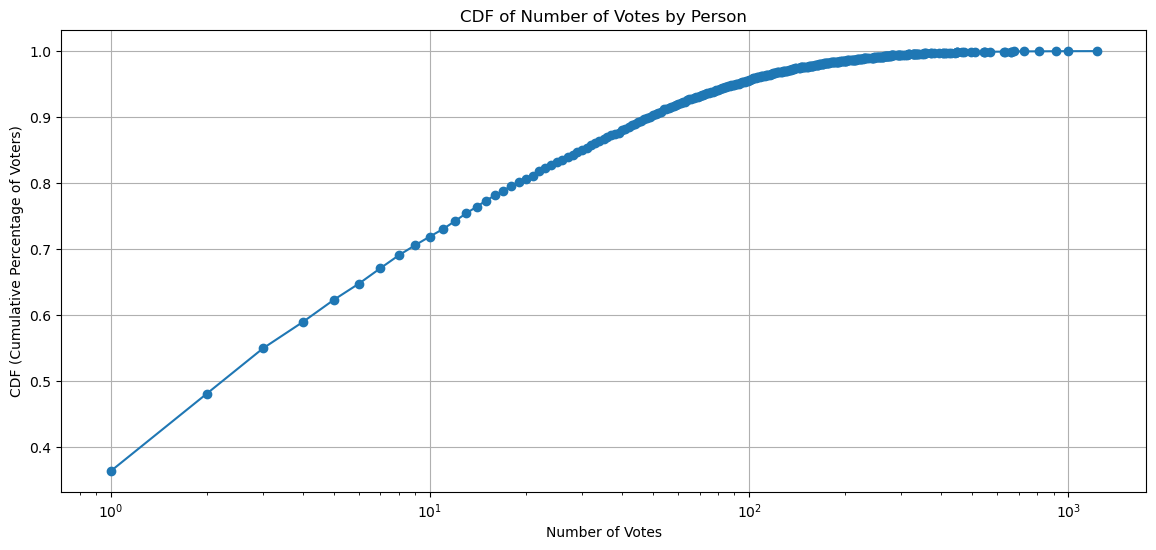

In [127]:
cdf = votes_distribution.value_counts().sort_index().cumsum() / len(votes_distribution) 

plt.figure(figsize=(14, 6))
plt.plot(cdf.index, cdf, marker='o', linestyle='-')
plt.xlabel('Number of Votes')
plt.ylabel('CDF (Cumulative Percentage of Voters)')
plt.title('CDF of Number of Votes by Person')
plt.xscale('log')
plt.grid(True)
plt.show()

In [128]:
print(f'Median of number of votes per voter: {votes_distribution.value_counts().sort_index().median()}')
print(f'Mean of number of votes per voter: {votes_distribution.value_counts().sort_index().mean()}')

Median of number of votes per voter: 3.0
Mean of number of votes per voter: 34.15081967213115


Looking at the CDF plot of the number of votes per person, we notice that half of the voters have voted less than 3 times, and 36% of the voters have only voted one time. <br>
The median of the number of votes per voter is 3 while the mean is 34, potentially signifying that our distribution is skewed to the right.

Let's analyse similarity of voters between each pair of years, this will allow us to see if the nature of voters change throughout the years.

In [140]:
voters_active_years = voters_df['Active Years']
unique_years = wiki_df['YEA'].unique()

results_df = pd.DataFrame(index=unique_years, columns=unique_years).astype(float)


In [141]:
# We go through pairs of years and extract the percentage of similar voters, we add them to a resulting dataframe
for y1 in unique_years:
    for y2 in unique_years:
        if y1 == y2:
            results_df.at[y1, y2] = 1
        else:
            results_df.at[y1, y2] = len(voters_active_years[voters_active_years.apply(lambda x: y1 in x and y2 in x)].index) / len(voters_active_years[voters_active_years.apply(lambda x: y1 in x)])


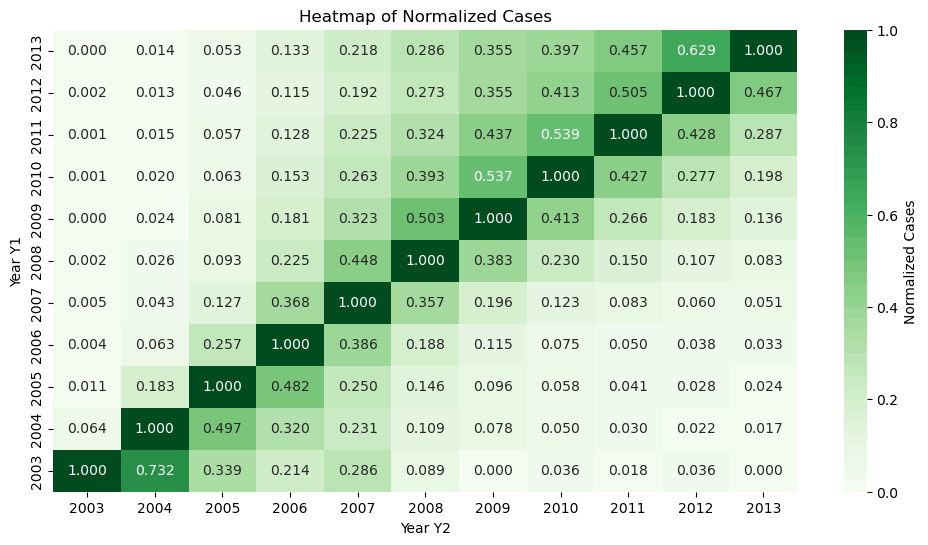

In [142]:
results_df = results_df.reindex(sorted(results_df.columns), axis=1)

plt.figure(figsize=(12, 6))
sns.heatmap(results_df, cmap=sns.color_palette("Greens", 40), annot=True, fmt=".3f", cbar_kws={'label': 'Normalized Cases'})

plt.xlabel('Year Y2')
plt.ylabel('Year Y1')
plt.title('Heatmap of Normalized Cases')

plt.show()

The heatmap reads like this : for a given pair of years ${y}_{i}, y_{j}$, the value in row $i$ and column $j$ is the percentage of voters in year $i$ that have also voted in year $j$.


The heatmap shows us that there is a lot of variability in the voters, and there aren't as many voters that are common between years as one would assume. However, this makes sense considering more than 50\% of voters have voted less than 4 times.

We can see higher values around the diagonal which shows the amount of common voters between close years, as the years drift apart, the number of common voters tend to reduce.

Such a vizualisation is important to see the correlation between the identities of voters between years. For instance, if we were ever to analyze text used in 2003 and compare it to the text used in 2013, we must be aware that there are no common voters between the two years, the analysis might thus reveal differences not because the language has changed, but rather because there are different voters using different language.

##### Candidates Exploration

We will now proceed with the same data exploration, but for candidates.

In [148]:
print(f'Number of unique candidates : {len(candidates_df["USER"])}')

Number of unique candidates : 3497


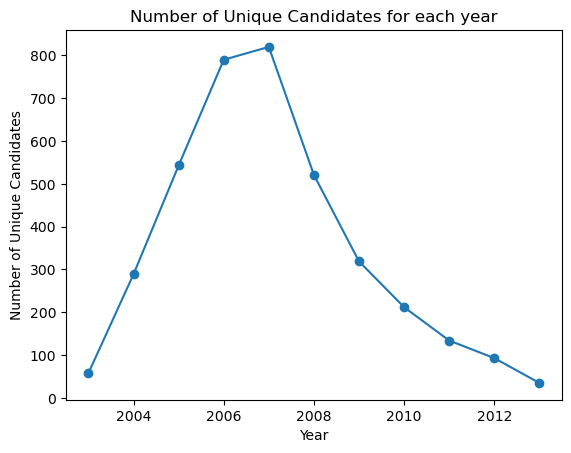

In [149]:
# Group by YEA and count the number of unique SRC
unique_candidates_per_year = wiki_df.groupby(wiki_df['YEA'])['TGT'].nunique()

plt.plot(unique_candidates_per_year.index, unique_candidates_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Unique Candidates')
plt.title('Number of Unique Candidates for each year')
plt.show()

##### Election Analysis

Now that we have successfully identified distinct elections, let's look at some statistics about the elections.

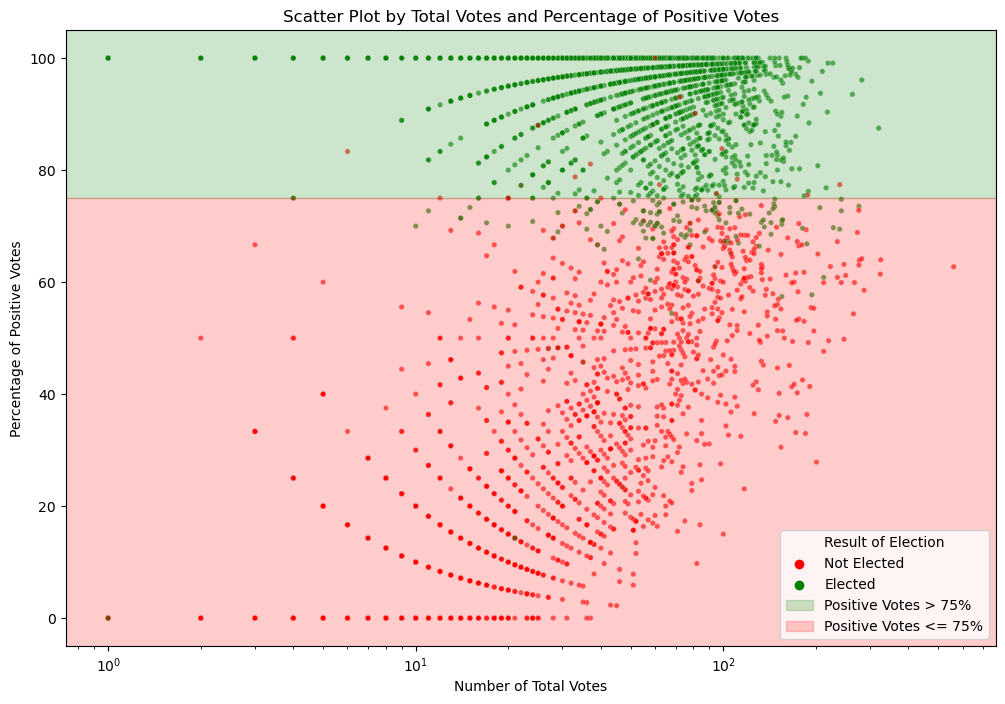

In [152]:
# Assuming 'total_votes', 'positive_percentage', and 'RES' are the columns in elections_df
plt.figure(figsize=(12, 8))

# Scatter plot with points colored by the percentage of positive votes
scatter = sns.scatterplot(x='total_votes', y='Positive Percentage', hue='RES', data=elections_df, palette={0: 'red', 1: 'green'}, s=15, alpha=0.6)

plt.axhspan(75, 105, color='green', alpha=0.2, label='Positive Votes > 75%')
plt.axhspan(-5, 75, color='red', alpha=0.2, label='Positive Votes <= 75%')

plt.title('Scatter Plot by Total Votes and Percentage of Positive Votes')
plt.xlabel('Number of Total Votes')
plt.ylabel('Percentage of Positive Votes')
plt.ylim(-5, 105)
plt.xscale('log')
plt.legend(title='Result of Election', loc='upper right', labels=['Not Elected', 'Elected'])

# Adjust the legend
handles, labels = scatter.get_legend_handles_labels()
labels[0] = 'Not Elected'
labels[1] = 'Elected'
scatter.legend(handles, labels, title='Result of Election', loc='lower right')

plt.show()

The wikipedia article about RfA elections states : "Consensus at RfA is not determined by surpassing a numerical threshold, but by the strength of rationales presented. In practice, most RfAs above 75% support pass." (https://en.wikipedia.org/wiki/Wikipedia:Requests_for_adminship).

The treshold is indeed noticeable, however, the plot shows that it is a bit below 75%. We can also notice that there are some exceptions that have a very high positive votes percentage, yet end up not being elected, and vice-versa. Which echoes the fact that a certain percentage of votes is not a guarantee of a successful election. However, the opposite seems to be true, indeed, for the vast majority of cases, it seems that having less than 50% of positive votes is a guarantee of failing the election.


But RfA is not a straightforward majority vote, there is no precise "pass" or "fail" percentage, the 75% is only given as an approximate guide and it is the job of bureaucrats to determine the concensus results of a request for admniship.


Indeed, there are even cases where candidates were rejected even if 100% of the votes they received were positives. Let's dig deeper into them.

In [186]:
elections_df[(elections_df['Positive Percentage'] == 100) & (elections_df['RES'] == 0)]

,ELECTION_ID,TGT,RES,YEA,positive_votes,neutral_votes,negative_votes,total_votes,positive_percentage,neutral_percentage,negative_percentage
1193,1194,matt037291,0,2008,1,0,0,1,100.0,0.0,0.0
2003,2004,Moralis,0,2007,1,0,0,1,100.0,0.0,0.0
2787,2788,LtPowers,0,2006,1,0,0,1,100.0,0.0,0.0
2793,2794,madcowpoo,0,2006,14,0,0,14,100.0,0.0,0.0
2950,2951,The Fish,0,2006,13,0,0,13,100.0,0.0,0.0
2988,2989,Weyes3,0,2006,1,0,0,1,100.0,0.0,0.0
3478,3479,Ilmari Karonen,0,2005,1,0,0,1,100.0,0.0,0.0
3483,3484,"Just zis Guy, you know?",0,2005,1,0,0,1,100.0,0.0,0.0
3494,3495,MarkGallagher,0,2005,2,0,0,2,100.0,0.0,0.0
3526,3527,Robchurch,0,2005,60,0,0,60,100.0,0.0,0.0


After conducting research on Wikipedia websites, specifically https://en.wikipedia.org/wiki/Wikipedia:Unsuccessful_adminship_candidacies/ + [first-letter-of-candidate], it becomes clear that, for the majority of these elections (with exceptions of `Moralis` and `Robchurch`), either the candidate refused the nomination, or the election was withdrawn by a bureaucrat who deemed the candidate unprepared. Thus, the margin remains at 1.0 due to the sudden end of the election but the recorded outcome is unsuccessful.

In the case of the candidate `Moralis`, the election followed a new experimental format of the RfA, which was not captured in this dataset.

The scenario involving the candidate `Robchurch` is particular. There were two distinct outcomes, initially negative and subsequently positive, for the same election. Unfortunately, the reasons for this dual outcome remain obscure.

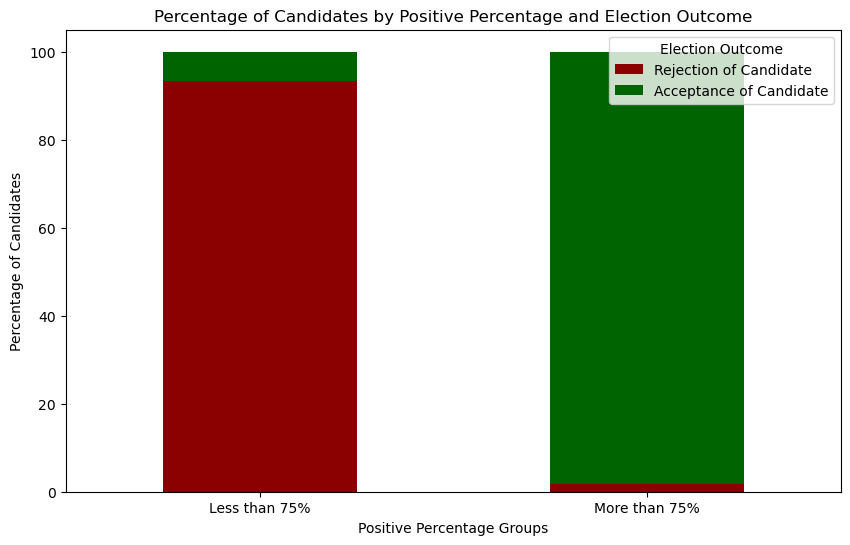

In [204]:
margin_df = elections_df.groupby(elections_df['Positive Percentage'].ge(75).map({True: 'More than 75%', False: 'Less than 75%'}))['RES'].value_counts(normalize=True).unstack() * 100

ax = margin_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['darkred', 'darkgreen'])

plt.xlabel('Positive Percentage Groups')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage of Candidates by Positive Percentage and Election Outcome')
plt.legend(title='Election Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
plt.xticks(rotation=0)

plt.show()

In [205]:
margin_df

RES,0,1
positive_percentage,,
Less than 75%,93.339632,6.660368
More than 75%,1.656543,98.343457


In summary, aspiring administrators should target a positive margin, as over $98\%$ of successful candidates exceed the indicative threshold of $75\%$ positive votes.

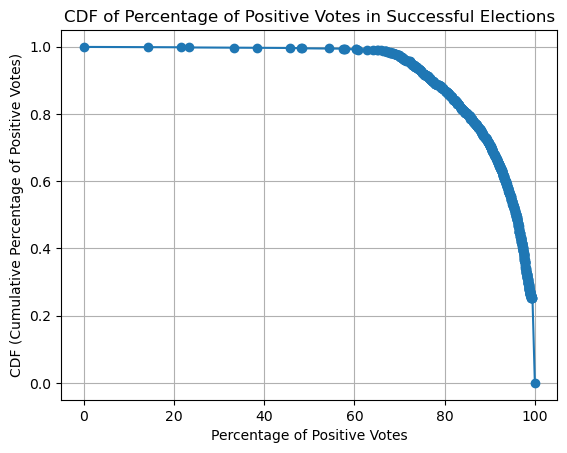

In [181]:
won_elections_distribution = elections_df[elections_df['RES'] == 1]['positive_percentage']
ccdf = 1 - won_elections_distribution.value_counts().sort_index().cumsum() / len(won_elections_distribution) 

plt.plot(ccdf.index, ccdf, marker='o', linestyle='-')
plt.xlabel('Percentage of Positive Votes')
plt.ylabel('CDF (Cumulative Percentage of Positive Votes)')
plt.title('CDF of Percentage of Positive Votes in Successful Elections')
plt.grid(True)
plt.show()

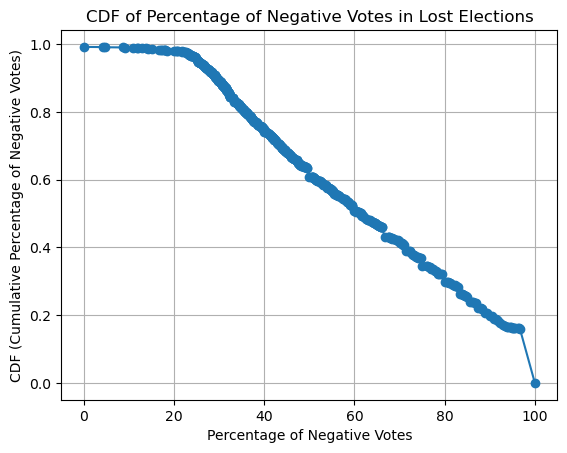

In [185]:
lost_elections_distribution = elections_df[elections_df['RES'] == 0]['Negative Percentage']
ccdf = 1 - lost_elections_distribution.value_counts().sort_index().cumsum() / len(lost_elections_distribution) 

plt.plot(ccdf.index, ccdf, marker='o', linestyle='-')
plt.xlabel('Percentage of Negative Votes')
plt.ylabel('CDF (Cumulative Percentage of Negative Votes)')
plt.title('CDF of Percentage of Negative Votes in Lost Elections')
plt.grid(True)
plt.show()

We notice that 80% of won elections have gathered more than 80% of positive votes, while 80% of lost elections had more than 30% of negative votes. This tells us that positive votes are important for the success of an election, but negative votes are not the only reasons a candidate might lose, this highlights the importance of positive votes. Indeed, a candidate might lose not because they have too many negative votes, but rather because they do not have enough positive ones. Hence the pivotal role neutral votes can play, and the importance of understanding why people vote positively, in order to convert the neutral votes into positive ones and change the outcome of an election.

In the third milestone, we will explore how neutral votes can effect the outcome of an election and analyse ways to sway them.

#### Neutral Votes

First, let's look at the distribution of the votes in our dataset.

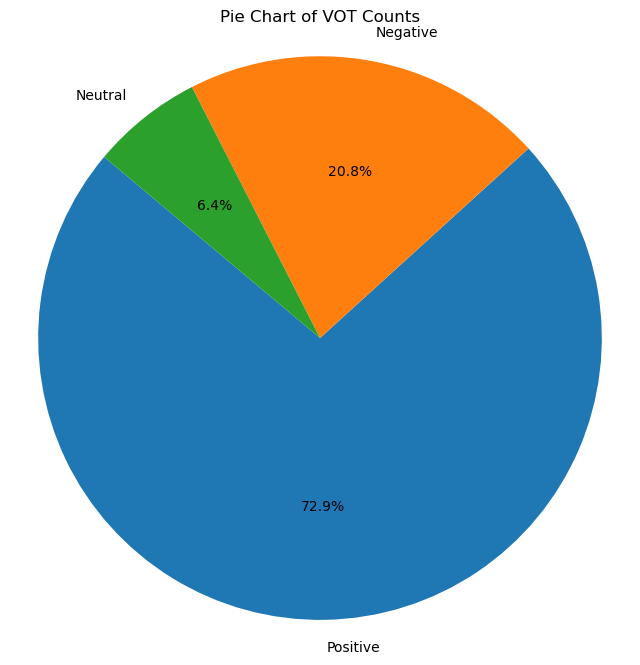

In [236]:
vote_counts = wiki_df['VOT'].value_counts()

label_map = {1: 'Positive', 0: 'Neutral', -1: 'Negative'}
vote_labels = [label_map[val] for val in vote_counts.index]

plt.figure(figsize=(8, 8))
plt.pie(vote_counts, labels=vote_labels, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of VOT Counts')
plt.axis('equal') 

plt.show()

We can see that neutral votes represent 6.4% of our total votes.

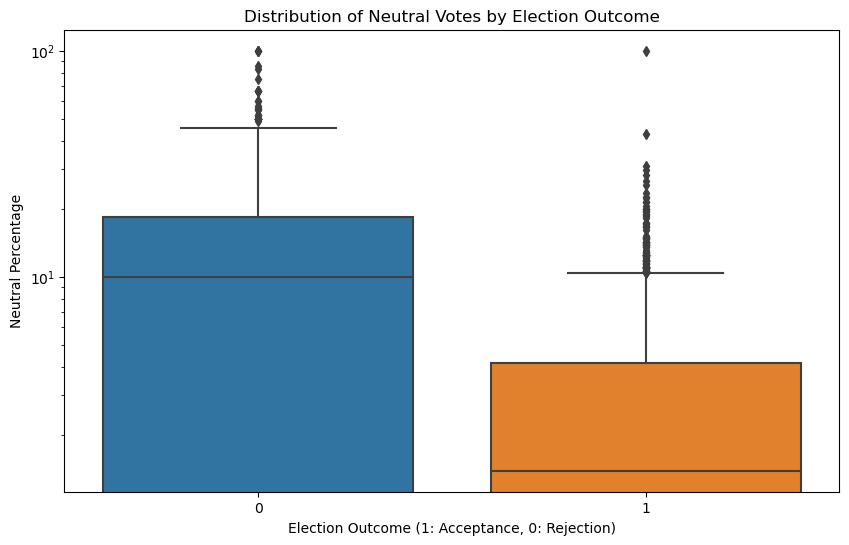

In [208]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='RES', y='Neutral Percentage', data=elections_df)
plt.xlabel('Election Outcome (1: Acceptance, 0: Rejection)')
plt.ylabel('Neutral Percentage')
plt.title('Distribution of Neutral Votes by Election Outcome')
plt.yscale('log')
plt.show()

Observing the boxplot, we notice a notable difference in the distribution of neutral votes between successful and unsuccessful elections. The median for unsuccessful elections is around $10\%$, while for successful elections, it is approximately $1\%$. This indicates a tendency for unsuccessful elections to have a higher proportion of neutral votes.

This motivates our project, indeed, by analysing the motives behind voting, we could possibly be able to change neutral votes into positive ones, changing the outcome of an election.

To confirm this observation, we will conduct a statistical test.

C:\Users\Akram\AppData\Local\Temp\ipykernel_16692\4123823473.py:11: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\Akram\AppData\Local\Temp\ipykernel_16692\4123823473.py:12: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])


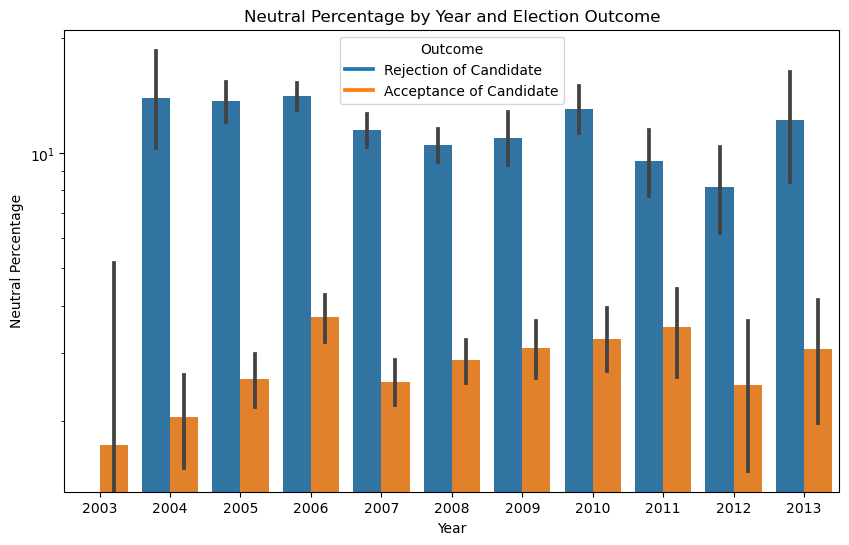

In [211]:
plt.figure(figsize=(10, 6))

sns.barplot(x='YEA', y='Neutral Percentage', hue='RES', data=elections_df)

plt.xlabel('Year')
plt.ylabel('Neutral Percentage')
plt.yscale('log')
plt.title('Neutral Percentage by Year and Election Outcome')

legend = plt.legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
legend.legendHandles[0].set_color(sns.color_palette()[0])
legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.show()

We notice that this holds true for all years and that there no drastic differences between years.

#### Influence of previous participation before running for adminship

For each candidate, we investigate the votes they cast before the start date of their election. We gather information on the total number of positive, negative, and neutral votes the candidate made, along with the average length of the comments they provided.

In [220]:
def summarize_before_adminship(row):
    election_id = row['ELECTION_ID']
    candidate = row['TGT']
    start_date = row['Earliest Voting Date']
    res = row['RES']
    
    candidate_votes_before = wiki_df[(wiki_df['SRC'] == candidate) & (wiki_df['DAT'] < start_date)]
    
    num_votes_no = (candidate_votes_before['VOT'] == -1).sum()
    num_votes_yes = (candidate_votes_before['VOT'] == 1).sum()
    num_votes_neutral = (candidate_votes_before['VOT'] == 0).sum()
    
    avg_comment_length = candidate_votes_before['TXT'].str.len().mean()
    
    return pd.Series({
        'ELECTION_ID': election_id,
        'TGT': candidate,
        'RES': res,
        'TotalNumPrevVotes' : num_votes_no + num_votes_yes + num_votes_neutral,
        'NumPrevVotesNo': num_votes_no,
        'NumPrevVotesYes': num_votes_yes,
        'NumPrevVotesNeutral': num_votes_neutral,
        'AvgPrevCommentLength': avg_comment_length
    })


summary_before_adminship_df = elections_df[['ELECTION_ID', 'TGT', 'RES', 'Earliest Voting Date']].drop_duplicates()
summary_before_adminship_df = summary_before_adminship_df.apply(summarize_before_adminship, axis=1)

In [221]:
summary_before_adminship_df['AvgPrevCommentLength'] = summary_before_adminship_df['AvgPrevCommentLength'].fillna(0)

summary_before_adminship_df

,ELECTION_ID,TGT,RES,TotalNumPrevVotes,NumPrevVotesNo,NumPrevVotesYes,NumPrevVotesNeutral,AvgPrevCommentLength
0,1,BDD,1,3,0,2,1,250.666667
1,2,Bilby,1,11,3,7,1,568.181818
2,3,Darkwind,1,0,0,0,0,0.000000
3,4,INeverCry,1,8,2,6,0,74.375000
4,5,Jason Quinn,1,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...
3923,3924,Tristanb,1,0,0,0,0,0.000000
3924,3925,Ugen64,1,0,0,0,0,0.000000
3925,3926,Vancouverguy,1,0,0,0,0,0.000000
3926,3927,WhisperToMe,1,0,0,0,0,0.000000


Now that we have the necessary information, we categorize the candidate into two groups: 'Without Previous Votes' if the candidate did not participate as a voter in any election before the beginning of their election and 'With Previous Votes' otherwise.

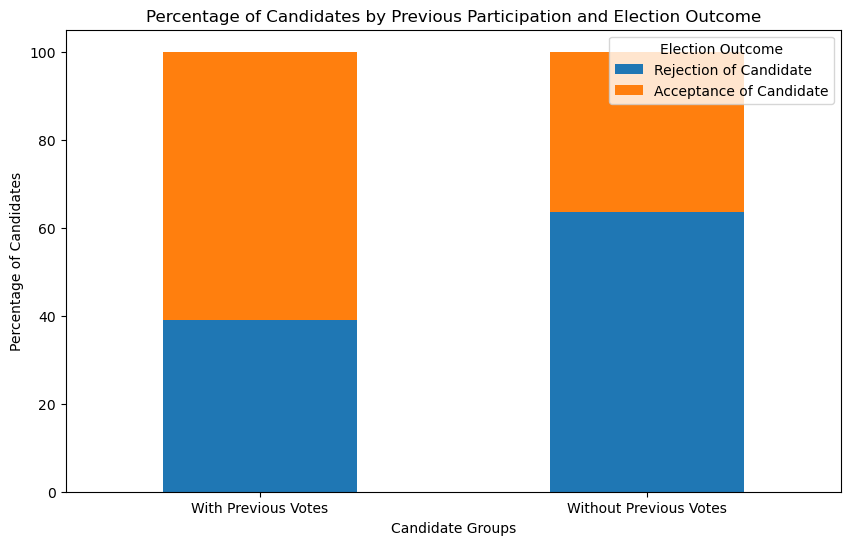

In [223]:
percentage_df = summary_before_adminship_df.groupby(summary_before_adminship_df['TotalNumPrevVotes'].eq(0).map({True: 'Without Previous Votes', False: 'With Previous Votes'}))['RES'].value_counts(normalize=True).unstack() * 100

ax = percentage_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Candidate Groups')
plt.ylabel('Percentage of Candidates')
plt.title('Percentage of Candidates by Previous Participation and Election Outcome')
plt.legend(title='Election Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
plt.xticks(rotation=0)

plt.show()

In [224]:
percentage_df

RES,0,1
TotalNumPrevVotes,,
With Previous Votes,38.980510,61.019490
Without Previous Votes,63.622211,36.377789


The bar chart reveals a contrast between candidates with prior participation in the voting process and those without. Notably, 61% of candidates with previous engagement were successfully accepted as administrators, whereas only 36% of candidates lacking prior participation received the same outcome.

To validate this observed difference statistically, let's conduct a hypothesis test.

Since we are comparing acceptance rates (a binary outcome) based on a categorical variable (previous participation), a chi-square test for independence is more suitable as it is used when analyzing the association between two categorical variables.

In [225]:
chi2, p, _, _ = chi2_contingency(percentage_df)

print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

Chi-square statistic: 11.186178160495032
P-value: 0.0008240891240052479


At a significance level of 0.05, the p-value falls below this threshold. Therefore, with 95% confidence, we reject the null hypothesis. This indicates a significant difference in acceptance rates between candidates with and without previous participation in the voting process.

Let's now condider the candidates who participated at least once in the previous elections before his request for adminship. Do the number of positive, negative or neutral votes they made or the length of the comments impact the result of their election?

In [226]:
tgt_with_prev_participation = summary_before_adminship_df[summary_before_adminship_df['TotalNumPrevVotes'] > 0]

C:\Users\Akram\AppData\Local\Temp\ipykernel_16692\2473272794.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\Akram\AppData\Local\Temp\ipykernel_16692\2473272794.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(sns.color_palette()[1])
C:\Users\Akram\AppData\Local\Temp\ipykernel_16692\2473272794.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(sns.color_palette()[0])
C:\Users\Akram\AppData\Local\Temp\ipykernel_16692\2473272794.py:19: MatplotlibDeprecationWarning: The legendHandles attri

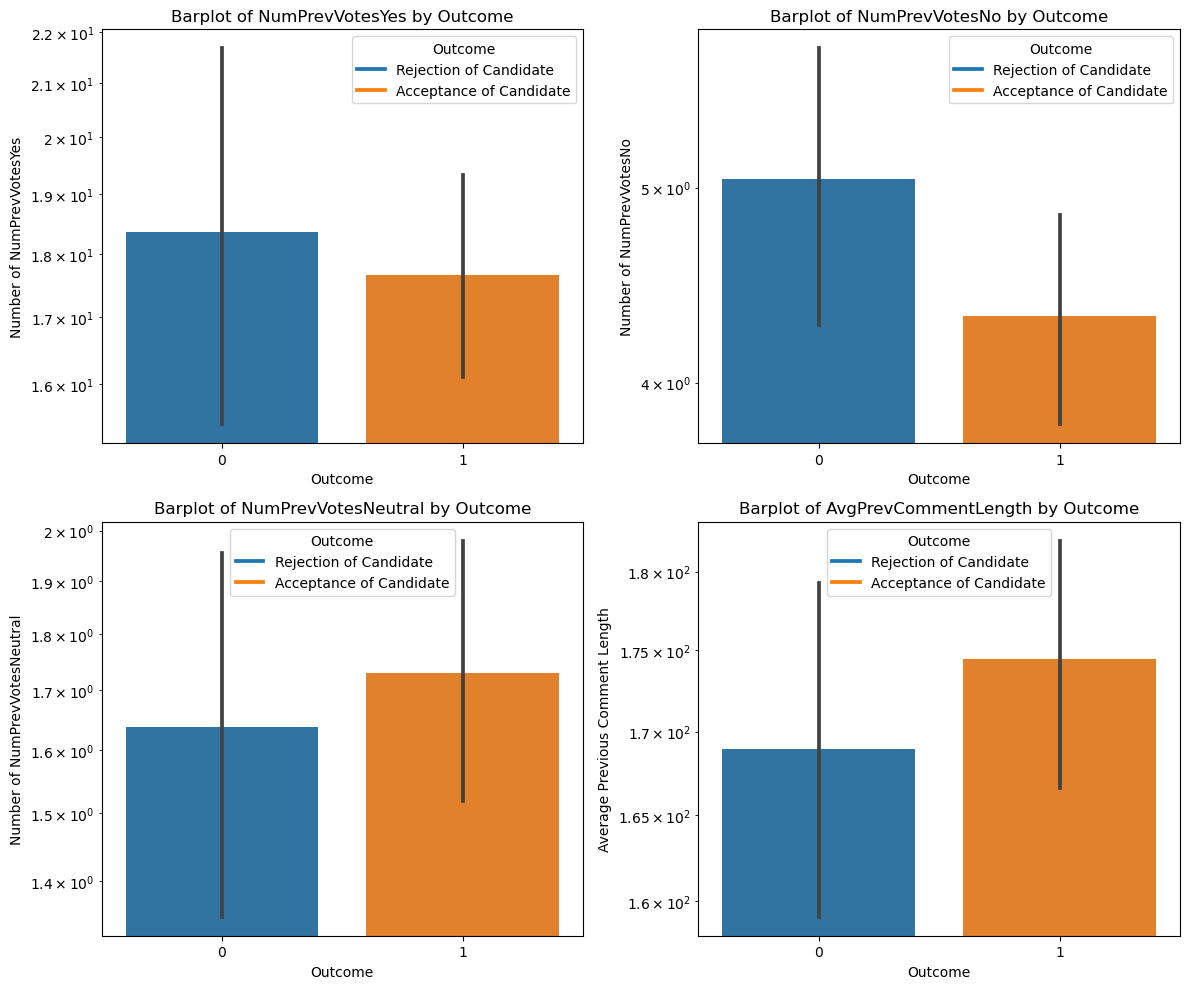

In [227]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Categories to plot
categories = ['NumPrevVotesYes', 'NumPrevVotesNo', 'NumPrevVotesNeutral', 'AvgPrevCommentLength']

for i, category in enumerate(categories):
    row = i // 2
    col = i % 2

    sns.barplot(x='RES', y=category, data=tgt_with_prev_participation, ax=axes[row, col])

    axes[row, col].set_ylabel(f'Number of {category}' if 'NumPrevVotes' in category else 'Average Previous Comment Length')
    axes[row, col].set_xlabel('Outcome')
    axes[row, col].set_title(f'Barplot of {category} by Outcome')
    axes[row, col].set_yscale('log')

    legend = axes[row, col].legend(title='Outcome', labels=['Rejection of Candidate', 'Acceptance of Candidate'])
    legend.legendHandles[0].set_color(sns.color_palette()[0])
    legend.legendHandles[1].set_color(sns.color_palette()[1])

plt.tight_layout()

plt.show()

Upon examining the bar plot for candidates with prior voting experience, it seems that the average number of previous positive, negative, or neutral votes, as well as the average comment length before their candidacy, is consistent regardless of acceptance or rejection.

To validate these observations, let's conduct a t-test to statistically confirm the similarity between accepted and rejected candidates.

In [229]:
t_test_results = {}

for category in categories:
    data_res_0 = tgt_with_prev_participation[tgt_with_prev_participation['RES'] == 0][category].dropna()
    data_res_1 = tgt_with_prev_participation[tgt_with_prev_participation['RES'] == 1][category].dropna()

    t_stat, p_value = ttest_ind(data_res_0, data_res_1, alternative='two-sided')

    t_test_results[category] = {'T-statistic': t_stat, 'P-value': p_value}
    
for category, result in t_test_results.items():
    print(f"Category: {category}")
    print(f"T-statistic: {result['T-statistic']}")
    print(f"P-value: {result['P-value']}")
    print()

Category: NumPrevVotesYes
T-statistic: 0.43884699900576585
P-value: 0.6608198290092218

Category: NumPrevVotesNo
T-statistic: 1.5819644296167288
P-value: 0.11381588454628705

Category: NumPrevVotesNeutral
T-statistic: -0.49770651236585023
P-value: 0.6187456606353676

Category: AvgPrevCommentLength
T-statistic: -0.8820169915910627
P-value: 0.37787366238526654



The statistical results reveal no substantial differences in the averages, both for the various categories of votes (positive, neutral, or negative) and the length of comments. This leads to the conclusion that candidates' prior voting behavior and comment length, before aspiring to adminship, may not significantly influence the outcome of their candidacy. 

#### Natural Language Processing

### Conclusion and Perspectives for Milestone 3

In our project's second phase, we polished the data for better usability, making it more consistent and neatly formatted across different DataFrames. This will allow us to dive straight into analysis without further processing. We also scouted for extra datasets containing Wikipedia users' statistics. This additional information will help us measure user activity and contributions within Wikipedia, a key aspect we suspect might tie into their performance in elections.

Using our processed DataFrames, we explored various election facets: voter and candidate counts, the distribution of election outcomes, and even dived into the textual content of the votes.

Now, with a deeper understanding of our data and prepared DataFrames, we're aiming to uncover why people vote the way they do by:

- Digging into data analysis to uncover correlations behind positive votes. We'll use the additional datasets, previous voting history, activity levels, and text length, to uncover any meaningful connections. Statistical tests will help us validate these correlations.

- Using NLP techniques like topic mining and sentiment analysis to dig deeper into the text within votes. We will try to extract common topics in positive votes and understand the sentiment embedded within them.

- Building a network representation of our data and calculating centrality measures. This will help us decipher the role that affinity and networking play in the voting process.

The continuation of the project will aim to uncover insights into the factors driving people's decisions during Wikipedia elections.
